In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/timeseries/Train.csv
/kaggle/input/timeseries/Test.csv


We are provided with a Time Series problem involving prediction of number of commuters of JetRail, a new high speed rail service by Unicorn Investors. We are provided with 2 years of data(Aug 2012-Sept 2014) and using this data we have to forecast the number of commuters for next 7 months.

In [2]:
import matplotlib.pyplot as plt 
df = pd.read_csv('../input/timeseries/Train.csv')
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [3]:
df.tail()

,ID,Datetime,Count
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


#### I’m subsetting and aggregating dataset at daily basis to explain the different methods.

- Subsetting the dataset from (August 2012 – Dec 2013)
- Creating train and test file for modeling. The first 14 months (August 2012 – October 2013) are used as training data and next 2 months (Nov 2013 – Dec 2013) as testing data.
- Aggregating the dataset at daily basis

In [4]:
#Subsetting the dataset
#Index 11856 marks the end of year 2013
df = pd.read_csv('../input/timeseries/Train.csv', nrows = 11856)

#Creating train and test set 
#Index 10392 marks the end of October 2013 
train=df[0:10392] 
test=df[10392:]

In [5]:
#Aggregating the dataset at daily level
df.Timestamp = pd.to_datetime(df.Datetime,format='%d-%m-%Y %H:%M') 
df.index = df.Timestamp 
df = df.resample('D').mean()
train.Timestamp = pd.to_datetime(train.Datetime,format='%d-%m-%Y %H:%M') 
train.index = train.Timestamp 
train = train.resample('D').mean() 
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp 
test = test.resample('D').mean()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  """
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  


In [6]:
train.head()

,ID,Count
Datetime,,
2012-08-25,11.5,3.166667
2012-08-26,35.5,3.666667
2012-08-27,59.5,2.583333
2012-08-28,83.5,2.416667
2012-08-29,107.5,2.500000


Let’s visualize the data (train and test together) to know how it varies over a time period.

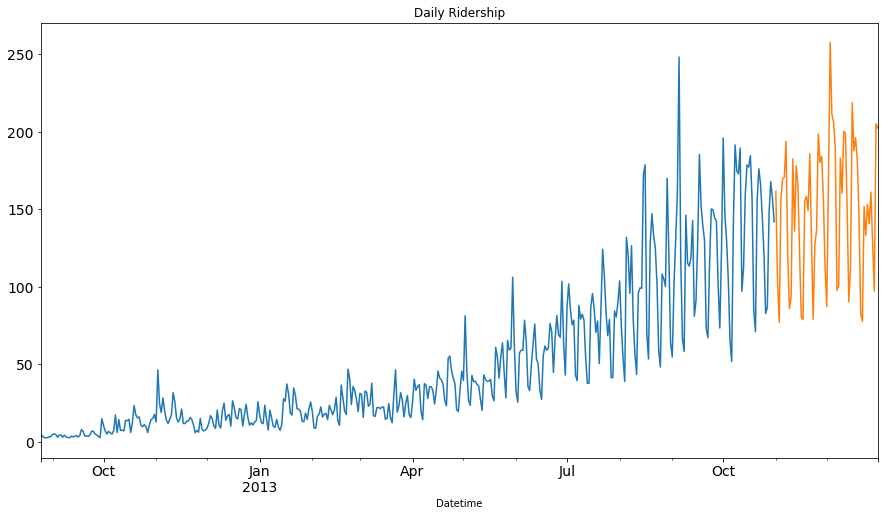

In [7]:
#Plotting data
train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
test.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14)
plt.show()

# Method 1: Start with a Naive Approach
Forecasting technique which assumes that the next expected point is equal to the last observed point is called Naive Method.
Now we will implement the Naive method to forecast the prices for test data.

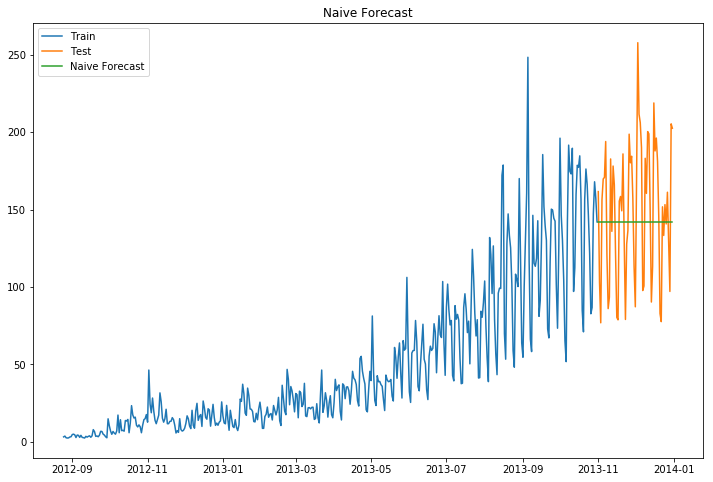

In [8]:
dd= np.asarray(train.Count)
y_hat = test.copy()
y_hat['naive'] = dd[len(dd)-1]
plt.figure(figsize=(12,8))
plt.plot(train.index, train['Count'], label='Train')
plt.plot(test.index,test['Count'], label='Test')
plt.plot(y_hat.index,y_hat['naive'], label='Naive Forecast')
plt.legend(loc='best')
plt.title("Naive Forecast")
plt.show()

We will now calculate RMSE to check to accuracy of our model on test data set.

In [9]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rms = sqrt(mean_squared_error(test.Count, y_hat.naive))
print(rms)

43.91640614391676


We can infer from the RMSE value and the graph above, that Naive method isn’t suited for datasets with high variability. It is best suited for stable datasets. We can still improve our score by adopting different techniques. Now we will look at another technique and try to improve our score.

# Method 2: – Simple Average
Forecasting technique which forecasts the expected value equal to the average of all previously observed points is called Simple Average technique.

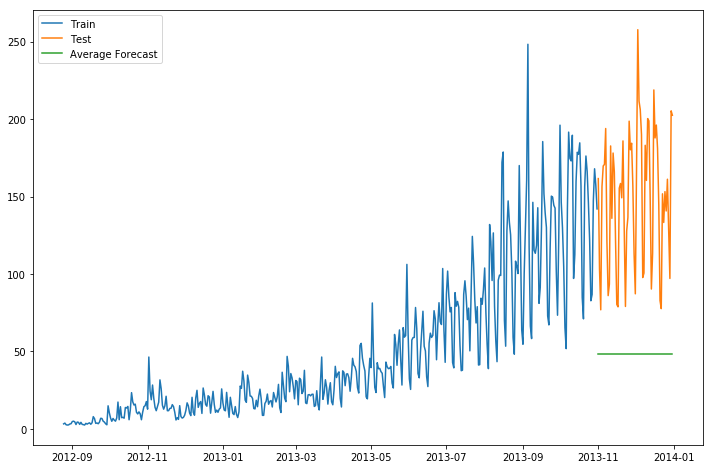

In [10]:
y_hat_avg = test.copy()
y_hat_avg['avg_forecast'] = train['Count'].mean()
plt.figure(figsize=(12,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['avg_forecast'], label='Average Forecast')
plt.legend(loc='best')
plt.show()

We will now calculate RMSE to check to accuracy of our model.

In [11]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.avg_forecast))
print(rms)

109.88526527082863


We can see that this model didn’t improve our score. Hence we can infer from the score that this method works best when the average at each time period remains constant. Though the score of Naive method is better than Average method, but this does not mean that the Naive method is better than Average method on all datasets. We should move step by step to each model and confirm whether it improves our model or not.

# Method 3 – Moving Average

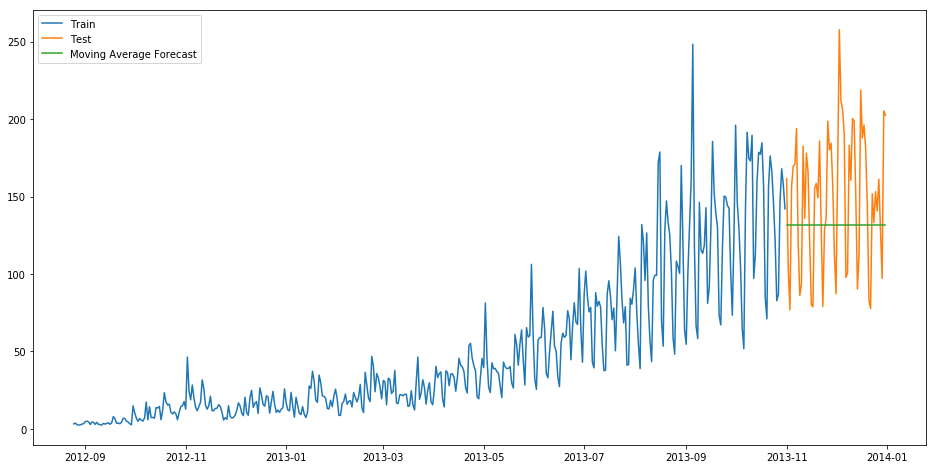

In [12]:
y_hat_avg = test.copy()
y_hat_avg['moving_avg_forecast'] = train['Count'].rolling(60).mean().iloc[-1]
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['moving_avg_forecast'], label='Moving Average Forecast')
plt.legend(loc='best')
plt.show()

We chose the data of last 2 months only. We will now calculate RMSE to check to accuracy of our model.

In [13]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.moving_avg_forecast))
print(rms)

46.72840725106963


We can see that Naive method outperforms both Average method and Moving Average method for this dataset. Now we will look at Simple Exponential Smoothing method and see how it performs.

# Method 4 – Simple Exponential Smoothing

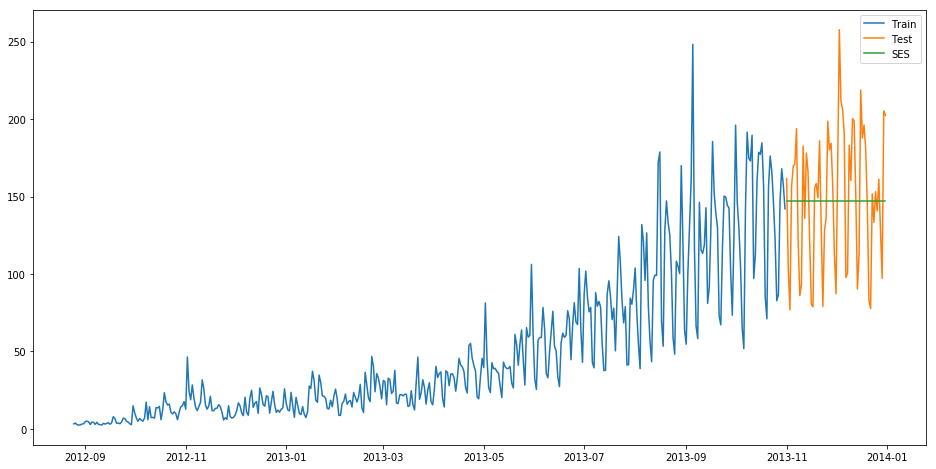

In [14]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg = test.copy()
fit2 = SimpleExpSmoothing(np.asarray(train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES'] = fit2.forecast(len(test)) # Simple Exponential Smoothing.
plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SES'], label='SES')
plt.legend(loc='best')
plt.show()

We will now calculate RMSE to check to accuracy of our model.

In [15]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SES))
print(rms)

43.357625225228155


We can see that implementing Simple exponential model with alpha as 0.6 generates a better model till now. We can tune the parameter using the validation set to generate even a better Simple exponential model.


# Method 5 – Holt’s Linear Trend method


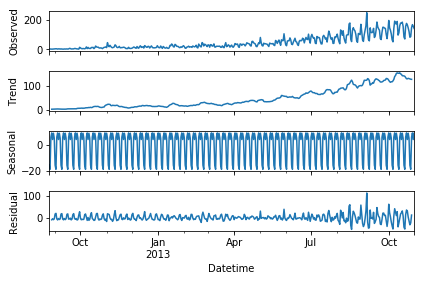

In [16]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(train.Count).plot()
result = sm.tsa.stattools.adfuller(train.Count)
plt.show()

Holt extended simple exponential smoothing to allow forecasting of data with a trend. It is nothing more than exponential smoothing applied to both level(the average value in the series) and trend. To express this in mathematical notation we now need three equations: one for level, one for the trend and one to combine the level and trend to get the expected forecast ŷ

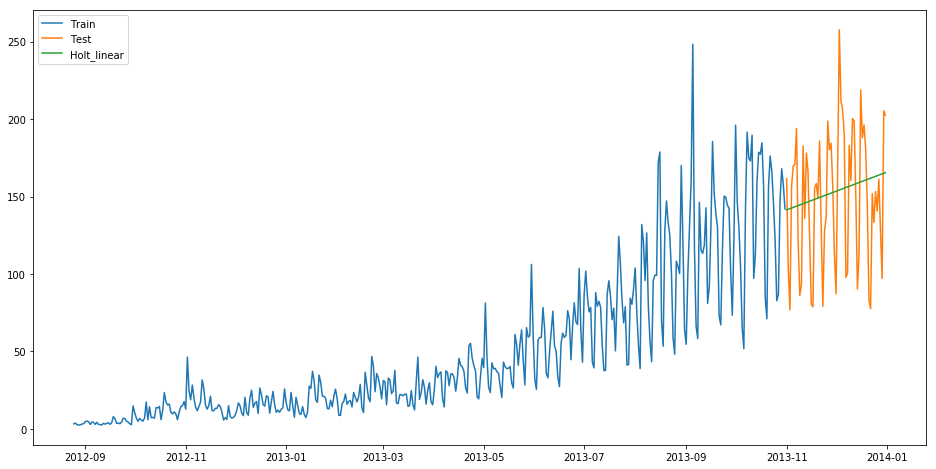

In [17]:
y_hat_avg = test.copy()

fit1 = Holt(np.asarray(train['Count'])).fit(smoothing_level = 0.3,smoothing_slope = 0.1)
y_hat_avg['Holt_linear'] = fit1.forecast(len(test))

plt.figure(figsize=(16,8))
plt.plot(train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_linear'], label='Holt_linear')
plt.legend(loc='best')
plt.show()

We will now calculate RMSE to check to accuracy of our model.

In [18]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_linear))
print(rms)

43.056259611507286


We can see that this method maps the trend accurately and hence provides a better solution when compared with above models. We can still tune the parameters to get even a better model.

# Method 6 – Holt-Winters Method

We need a method that takes into account both trend and seasonality to forecast future prices. One such algorithm that we can use in such a scenario is Holt’s Winter method. The idea behind triple exponential smoothing(Holt’s Winter) is to apply exponential smoothing to the seasonal components in addition to level and trend.

/opt/conda/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:712: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


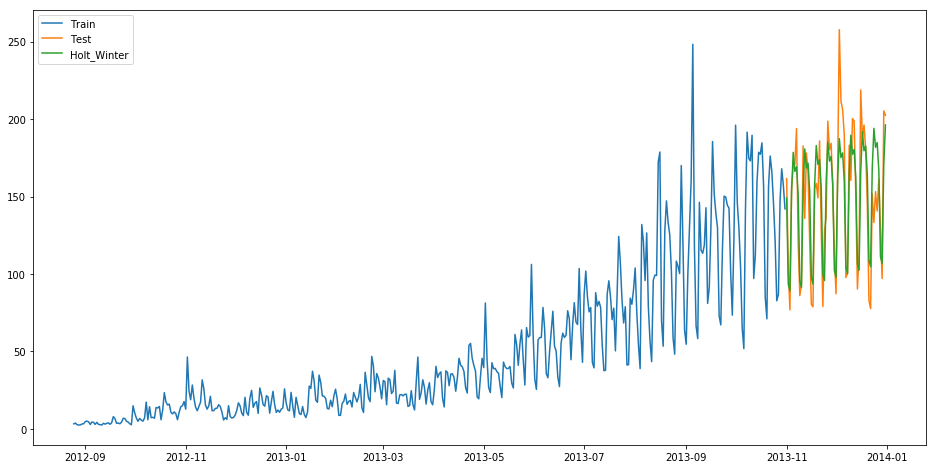

In [19]:
y_hat_avg = test.copy()
fit1 = ExponentialSmoothing(np.asarray(train['Count']) ,seasonal_periods=7 ,trend='add', seasonal='add',).fit()
y_hat_avg['Holt_Winter'] = fit1.forecast(len(test))
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['Holt_Winter'], label='Holt_Winter')
plt.legend(loc='best')
plt.show()

We will now calculate RMSE to check to accuracy of our model.

In [20]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.Holt_Winter))
print(rms)

23.961492566159794


We can see from the graph that mapping correct trend and seasonality provides a far better solution. We chose seasonal_period = 7 as data repeats itself weekly. Other parameters can be tuned as per the dataset. I have used default parameters while building this model. You can tune the parameters to achieve a better model.

# Method 7 – ARIMA
Another common Time series model that is very popular among the Data scientists is ARIMA. It stand for Autoregressive Integrated Moving average. While exponential smoothing models were based on a description of trend and seasonality in the data, ARIMA models aim to describe the correlations in the data with each other. An improvement over ARIMA is Seasonal ARIMA. It takes into account the seasonality of dataset just like Holt’ Winter method. 

/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


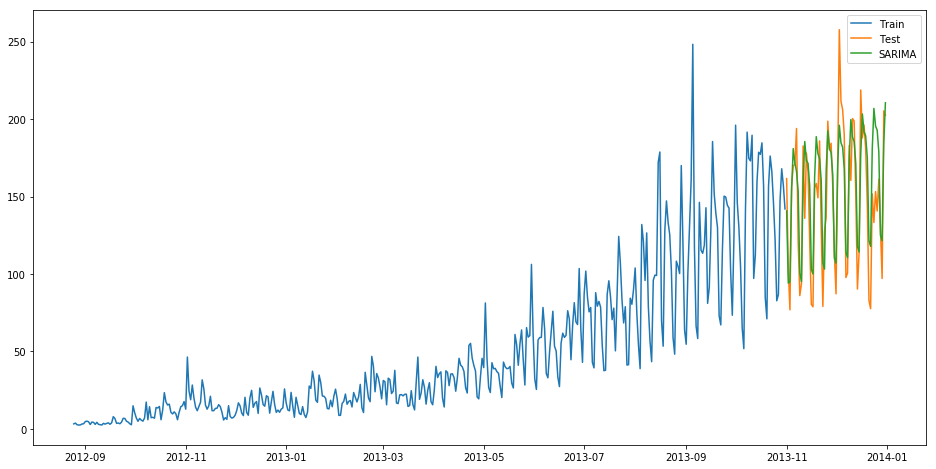

In [21]:
y_hat_avg = test.copy()
fit1 = sm.tsa.statespace.SARIMAX(train.Count, order=(2, 1, 4),seasonal_order=(0,1,1,7)).fit()
y_hat_avg['SARIMA'] = fit1.predict(start="2013-11-1", end="2013-12-31", dynamic=True)
plt.figure(figsize=(16,8))
plt.plot( train['Count'], label='Train')
plt.plot(test['Count'], label='Test')
plt.plot(y_hat_avg['SARIMA'], label='SARIMA')
plt.legend(loc='best')
plt.show()

We will now calculate RMSE to check to accuracy of our model.



In [22]:
rms = sqrt(mean_squared_error(test.Count, y_hat_avg.SARIMA))
print(rms)

26.05093558075804


Model                | RMSE 
---------------------|------
Naive Method         |  43.9 
Simple Average       | 109.5
Moving Average       | 46.72
Simple Exponential S.| 43.35
Holt's Linear trend  | 43.05
Holt's Winter        | 23.96
ARIMA                | 26.06

We can see that using Seasonal ARIMA generates a similar solution as of Holt’s Winter.

Thank You